In [1]:
# 기본
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# 경고 뜨지 않게 설정
import warnings
warnings.filterwarnings('ignore')

# 그래프 설정
sns.set()

# 그래프 기본 설정
plt.rcParams['font.family'] = 'Malgun Gothic'
# plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['figure.figsize'] = 12, 6
plt.rcParams['font.size'] = 14
plt.rcParams['axes.unicode_minus'] = False

# 데이터 전처리 알고리즘
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler

# 학습용과 검증용으로 나누는 함수
from sklearn.model_selection import train_test_split

# 교차 검증
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold

# 평가함수
# 분류용
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import roc_auc_score

# 회귀용
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

# 모델의 최적의 하이퍼 파라미터를 찾기 위한 도구
from sklearn.model_selection import GridSearchCV

# 머신러닝 알고리즘 - 분류
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier
from lightgbm import LGBMClassifier
from xgboost import XGBClassifier
from sklearn.ensemble import VotingClassifier

# 머신러닝 알고리즘 - 회귀
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from lightgbm import LGBMRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import VotingRegressor

# 학습 모델 저장을 위한 라이브러리
import pickle

# 시간 관련
import time

In [2]:
from sklearn.model_selection import StratifiedKFold

# 모델 저장 경로
best_model_path = 'model/best_model_classification_4.dat'

# Stratified K-Fold 설정 (분류에 적합)
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 평가 결과를 저장할 리스트
f1_score_list = []
model_name_list = []

### 데이터 준비

In [4]:
# 데이터 준비
df1 = pd.read_csv('data/청구입금정보_최종전처리.csv')

In [5]:
from sklearn.preprocessing import LabelEncoder, StandardScaler

# 1. Segment 인코딩
encoder1 = LabelEncoder()
df1["Segment"] = encoder1.fit_transform(df1["Segment"])

# 2. ID, 기준년월 제거 후 입력(X), 결과(y) 정의
X = df1.drop(['Segment', 'ID', '기준년월'], axis=1)
y = df1['Segment']  # 이미 인코딩된 상태

# 3. 입력 데이터 표준화
scaler1 = StandardScaler()
X2 = scaler1.fit_transform(X)

# 4. 학습용 데이터 할당
train_X = X2
train_y = y

### 기본 모델 학습하기

In [7]:
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
import pandas as pd

# F1 점수 저장용 리스트
f1_score_list = []
model_name_list = []

# XGBoost 모델 (CPU 사용)
xgboost_basic_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss',
    verbosity=0
)

# 교차 검증 (F1 Micro 기준)
r1 = cross_val_score(xgboost_basic_model, train_X, train_y, scoring='f1_micro', cv=cv)

# 결과 저장
f1_score_list.append(r1.mean())
model_name_list.append("XGBoost Basic (CPU)")

# 결과 테이블 생성 및 정렬
d1 = {'f1_micro score': f1_score_list}
result_df = pd.DataFrame(d1, index=model_name_list)
result_df.sort_values(by='f1_micro score', ascending=False, inplace=True)

# 결과 출력
display(result_df)

,f1_micro score
XGBoost Basic (CPU),0.842002


### 최종 점검

In [9]:
from xgboost import XGBClassifier

# 최종 모델 학습 (CPU 사용)
best_model = XGBClassifier(
    use_label_encoder=False,
    eval_metric='mlogloss'
)

# 모델 학습
best_model.fit(train_X, train_y)

# 완료 메시지
print("✅ CPU 사용 학습 완료")

✅ CPU 사용 학습 완료


In [10]:
from xgboost import plot_importance
import matplotlib.pyplot as plt
import pandas as pd

# 1. feature name 복원 (X는 학습 데이터, 컬럼 이름 리스트로 추출)
feature_names = X.columns.tolist() # 전처리 전 컬럼 이름
booster = best_model.get_booster()
booster.feature_names = feature_names  # booster에 직접 할당

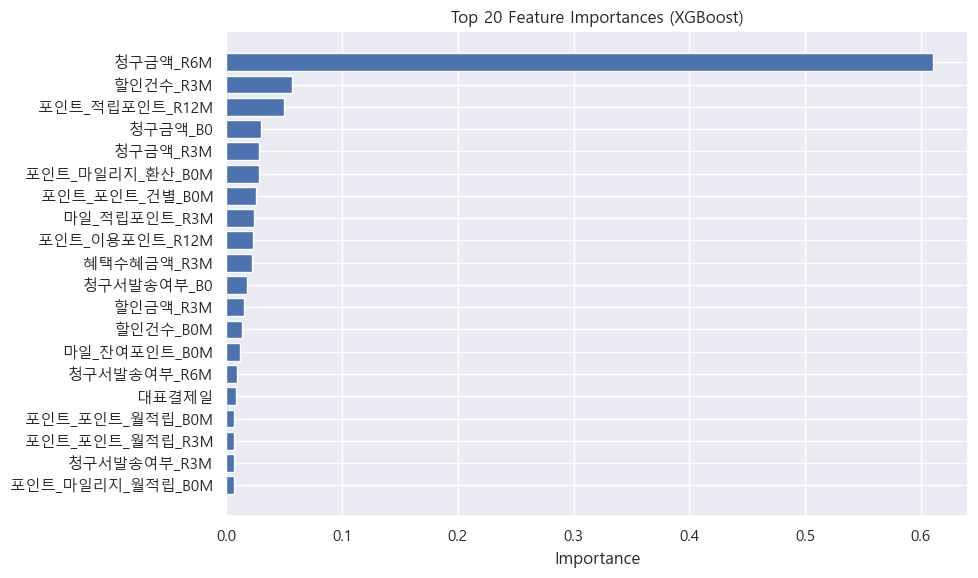

In [11]:
# 2. Feature importance 수치 추출 및 시각화 (gain 기준)
importances = best_model.feature_importances_

feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values(by='importance', ascending=False)

# 3. 상위 20개 bar 시각화
plt.figure(figsize=(10, 6))
plt.barh(
    feature_importance_df['feature'][:20][::-1], 
    feature_importance_df['importance'][:20][::-1]
)
plt.xlabel('Importance')
plt.title('Top 20 Feature Importances (XGBoost)')
plt.tight_layout()
plt.show()

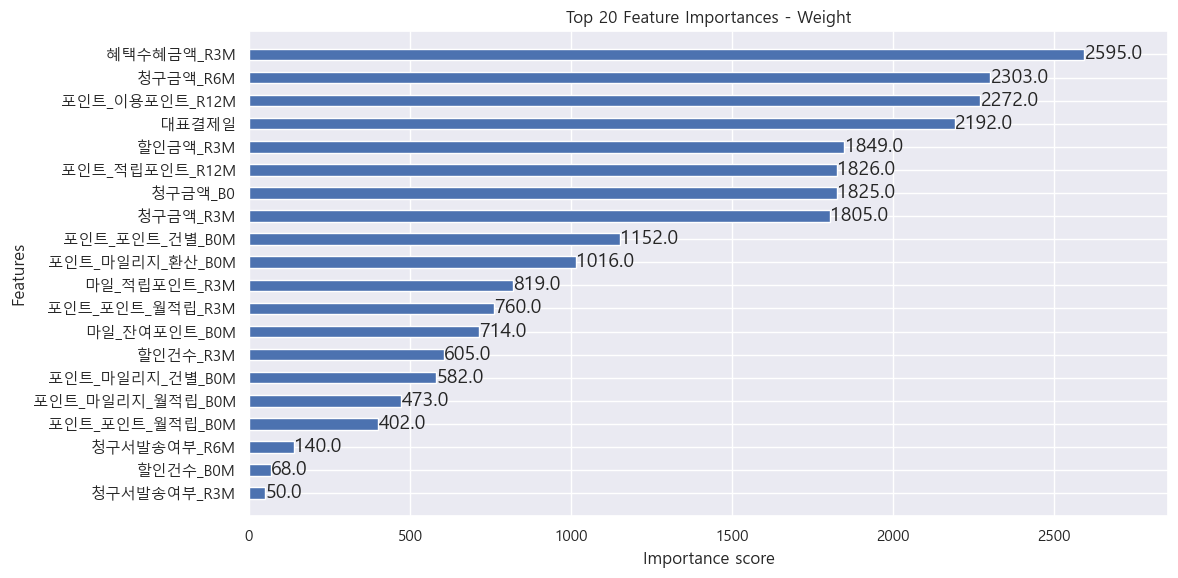

In [12]:
# 4. XGBoost 기본 제공 plot_importance (중복 import 제거)
plot_importance(
    booster, 
    max_num_features=20, 
    height=0.5, 
    importance_type='weight'  # 'gain', 'cover', 'weight' 중 선택 가능
)
plt.title('Top 20 Feature Importances - Weight')
plt.tight_layout()
plt.show()

### SHAP

 97%|=================== | 2416/2500 [00:24<00:00]       

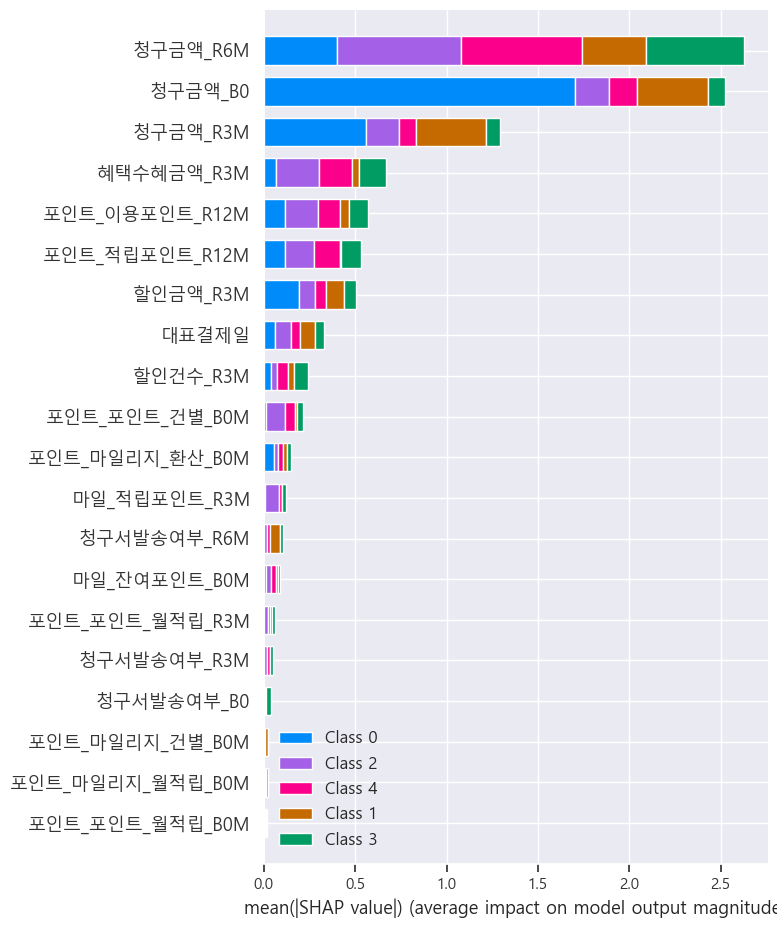

In [14]:
import shap
import matplotlib.pyplot as plt
import pandas as pd

# ✅ DataFrame으로 변환된 X에서 인덱스를 기준으로 추출
# 예: train_X는 numpy array지만, X는 원본 DataFrame이라고 가정
X_df = pd.DataFrame(train_X, columns=feature_names)

# 샘플 일부만 추출
X_sample = X_df.sample(n=500, random_state=42)

# SHAP Explainer 생성
explainer = shap.Explainer(best_model, X_df)

# SHAP 값 계산
shap_values = explainer(X_sample)

# summary plot
shap.summary_plot(shap_values, X_sample, plot_type="bar")

In [15]:
# 학습 모델 등을 저장한다.
with open(best_model_path, 'wb') as fp :
    pickle.dump(best_model, fp)
    pickle.dump(encoder1, fp)
    pickle.dump(scaler1, fp)

print('저장완료')

저장완료


In [16]:
# 저장 확인
with open(best_model_path, 'rb') as fp :
    test_model = pickle.load(fp)
    test_encoder = pickle.load(fp)
    test_scaler1 = pickle.load(fp)

📌 F1 Score (micro): 0.8451

📊 Classification Report:
              precision    recall  f1-score   support

           A       0.94      0.36      0.52       972
           B       1.00      0.67      0.80       144
           C       0.62      0.38      0.47    127590
           D       0.54      0.38      0.45    349242
           E       0.89      0.96      0.92   1922052

    accuracy                           0.85   2400000
   macro avg       0.80      0.55      0.63   2400000
weighted avg       0.82      0.85      0.83   2400000

📊 Confusion Matrix:
[[    346       0     605      16       5]
 [      0      97      37       8       2]
 [     16       0   48955   44363   34256]
 [      4       0   20651  132347  196240]
 [      1       0    8812   66707 1846532]]


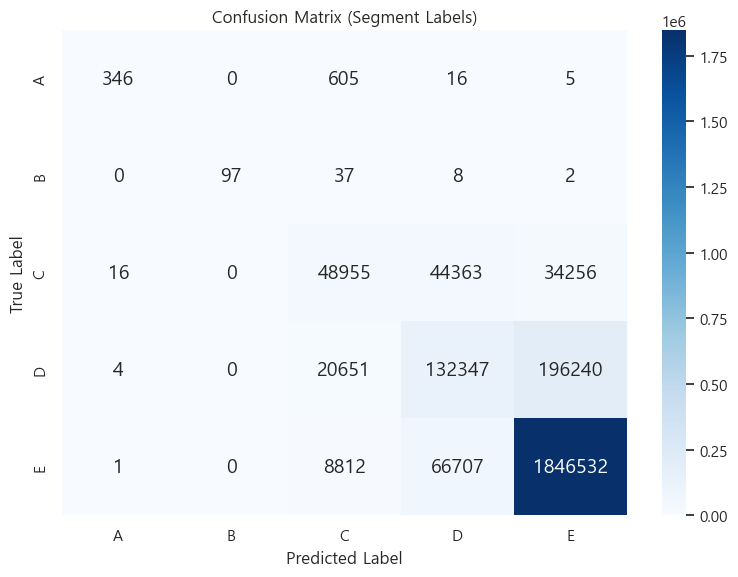

In [17]:
from sklearn.metrics import f1_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 예측
y_pred = test_model.predict(train_X)

# 📌 F1 점수 계산 (macro)
f1 = f1_score(train_y, y_pred, average='micro')
print(f"📌 F1 Score (micro): {f1:.4f}")

# ✅ 원래 세그먼트 라벨로 복원
true_labels = encoder1.inverse_transform(train_y)
pred_labels = encoder1.inverse_transform(y_pred)
label_names = encoder1.classes_  # ['A', 'B', 'C', 'D', 'E']

# 📊 Classification Report (라벨명 기준)
print("\n📊 Classification Report:")
print(classification_report(true_labels, pred_labels, target_names=label_names))

# 📊 Confusion Matrix
cm = confusion_matrix(true_labels, pred_labels, labels=label_names)
print("📊 Confusion Matrix:")
print(cm)

# 🎨 시각화
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=label_names, yticklabels=label_names)
plt.title("Confusion Matrix (Segment Labels)")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()